In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
torch.manual_seed(42)

In [3]:
device='cuda'

In [4]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [5]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [6]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [7]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

In [8]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [9]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [10]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [11]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is 1/3 the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [12]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece
# val_df1 = first_piece[int(n*0.4):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
# val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)
# val_seq1, val_labels1 = create_sequences(val_df1.values, 60)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
# val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
# val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece
# val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
# val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)
# val_seq2, val_labels2 = create_sequences(val_df2.values, 90)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)
# val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device=device)  # (batch, seq_length, input_dim)
# val_label_tensor2 = torch.FloatTensor(val_labels2).to(device=device)  # (batch, output_dim)

In [14]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece
# val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
# val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)
# val_seq3, val_labels3 = create_sequences(val_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device=device) # (batch, output_dim)
# val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device=device)  # (batch, seq_length, input_dim)
# val_label_tensor3 = torch.FloatTensor(val_labels3).to(device=device)  # (batch, output_dim)

In [15]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device=device) # (batch, output_dim)

In [16]:
len(train_labels1), len(train_seq1), len(train_df1.values)

(842, 842, 961)

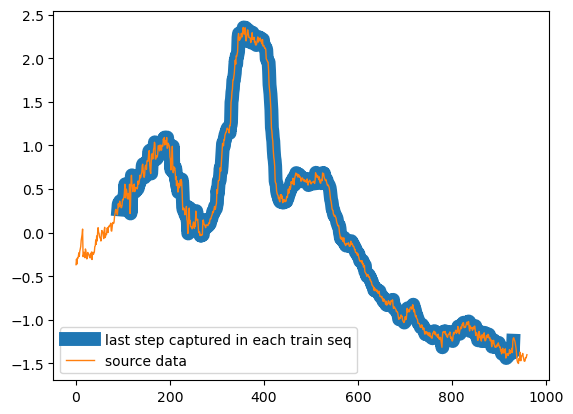

In [17]:
# first sequence - point 90 is plotted, then seconds sequence - 91, etc.
plt.plot(range(90,len(train_df1.values) + 1 - 30),train_seq1[:, -1, :], linewidth=10,  label='last step captured in each train seq')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

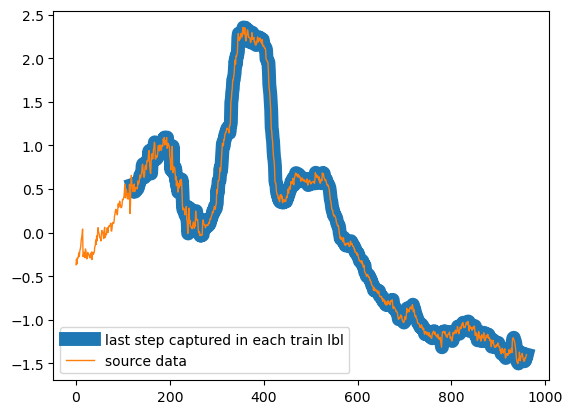

In [18]:
# the first last prediction is x_120, then x_121, etc.
# the last last prediction is 
plt.plot(range(120,len(train_df1.values)+1), train_labels1[:, -1, :], linewidth=10,  label='last step captured in each train lbl')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

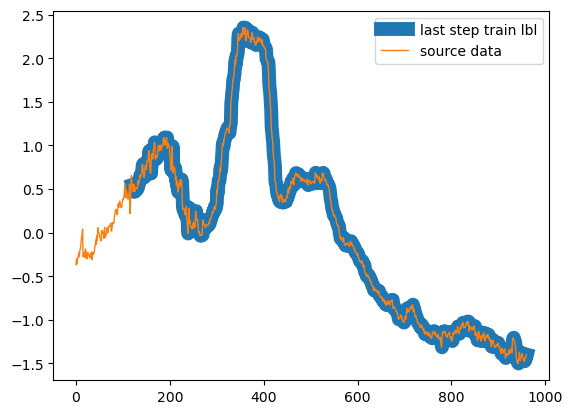

In [19]:
# the first last prediction is 120, then 121, etc.
plt.plot(range(120,len(train_df1.values)+1), train_labels1[:, -1, :], linewidth=10,  label='last step train lbl')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

### Creating Test Sequences

In [20]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 90)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 90)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 90)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 90)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 30)
        # self.fc2 = nn.Linear(30, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        # print(out.shape)
        out = self.fc1(out[:,-1, :]) # take the last hidden state because we assume it encodes all the information about the sequence
        # out = self.fc2(out[, :])  # Take the last 30 time step output
        return out.unsqueeze(2)

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU
criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

In [22]:
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model1(train_seq_tensor1)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

# train_losses = []
# val_losses = []
# for epoch in range(num_epochs):

#     for i in range(len(train_seq_tensor1)):
#         model1.train()
    
#         optimizer1.zero_grad()
#         y_pred = model1(train_seq_tensor1[i])
#         loss = criterion1(y_pred, train_label_tensor1[i])
#         # print(y_pred.shape)
#         # print(loss.item())
#         loss.backward()
#         optimizer1.step()
    
#         train_losses.append(loss.item())

#     # Validation
#     model1.eval()
    
#     if epoch % 10 == 0:
#         # with torch.no_grad():
#         #     for i in range(len(val_seq_tensor1)):
#         #         y_val = model123(val_seq_tensor1[i])
#         #         val_loss = criterion123(y_val, val_label_tensor1[i])
#         #         val_losses.append(val_loss.item())
#         print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4783779978752136
Epoch 10, Train Loss: 0.4753434956073761
Epoch 20, Train Loss: 0.4674391448497772
Epoch 30, Train Loss: 0.4318515956401825
Epoch 40, Train Loss: 0.2707573175430298
Epoch 50, Train Loss: 0.17363795638084412
Epoch 60, Train Loss: 0.130163311958313
Epoch 70, Train Loss: 0.1158125102519989
Epoch 80, Train Loss: 0.09714887291193008
Epoch 90, Train Loss: 0.08358844369649887
Epoch 100, Train Loss: 0.07416834682226181
Epoch 110, Train Loss: 0.06857936829328537
Epoch 120, Train Loss: 0.0651521161198616
Epoch 130, Train Loss: 0.062423255294561386
Epoch 140, Train Loss: 0.05998631939291954
Epoch 150, Train Loss: 0.05767514929175377
Epoch 160, Train Loss: 0.055317994207143784
Epoch 170, Train Loss: 0.052738599479198456
Epoch 180, Train Loss: 0.049704402685165405
Epoch 190, Train Loss: 0.04572592303156853
Epoch 200, Train Loss: 0.039890389889478683
Epoch 210, Train Loss: 0.036315787583589554
Epoch 220, Train Loss: 0.03492087870836258
Epoch 230, Train Loss: 0.

### Save the model

In [23]:
torch.save(model1.state_dict, 'model1_30step')

torch.Size([30, 1])

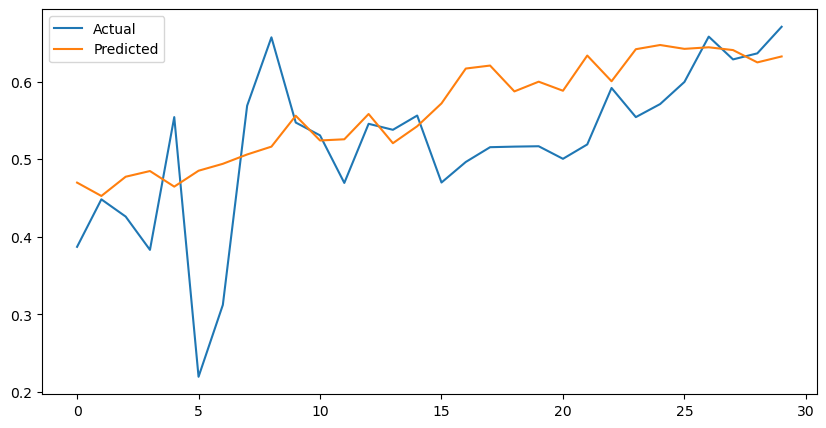

In [24]:
model1.eval()
y_test_label = train_label_tensor1[20]
y_test_seq = train_seq_tensor1[20]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()
y_test_label.shape

In [25]:
MARE(y_pred_test, y_test_label).item()

0.16549119353294373

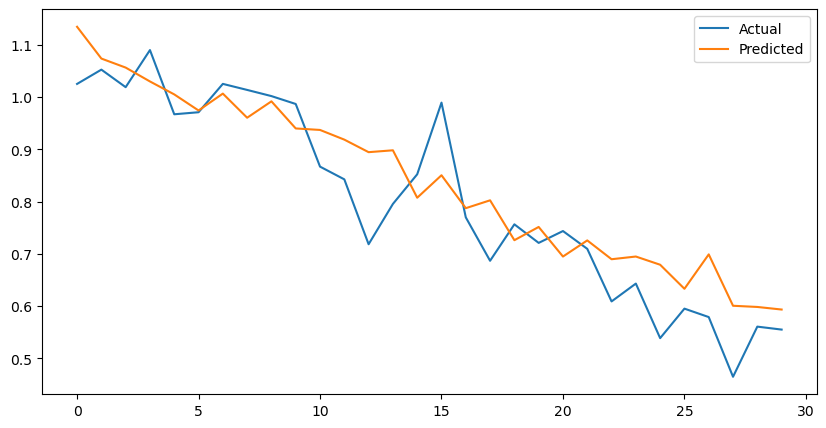

In [26]:
y_test_label = train_label_tensor1[100]
y_test_seq = train_seq_tensor1[100]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()

In [27]:
MARE(y_pred_test, y_test_label).item()

0.08881070464849472

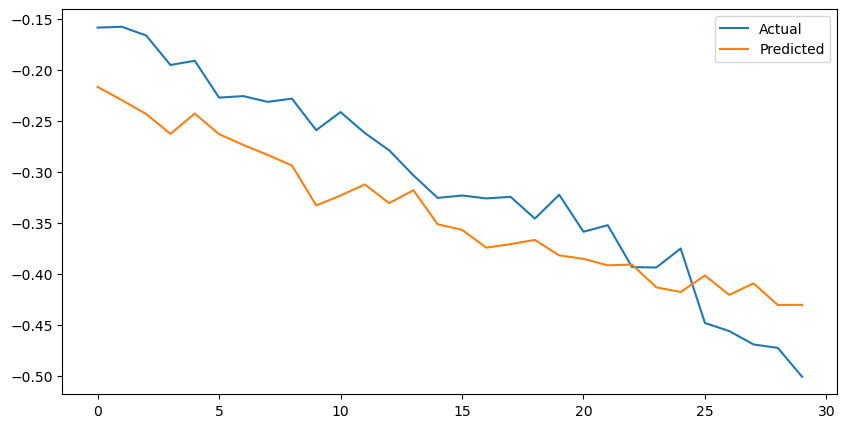

In [28]:
y_test_label = train_label_tensor1[500]
y_test_seq = train_seq_tensor1[500]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()

In [29]:
model1.eval()
error = 0
n_sequences = len(train_seq_tensor1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = train_seq_tensor1[i]
    y_test_label = train_label_tensor1[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    mare = MARE(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.29971041383814606


In [30]:
model1.eval()
error = 0
n_sequences = len(train_seq_tensor2)
for i in range(n_sequences):
    y_test_seq = train_seq_tensor2[i]
    y_test_label = train_label_tensor2[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    mare = MARE(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 1.778346219074887


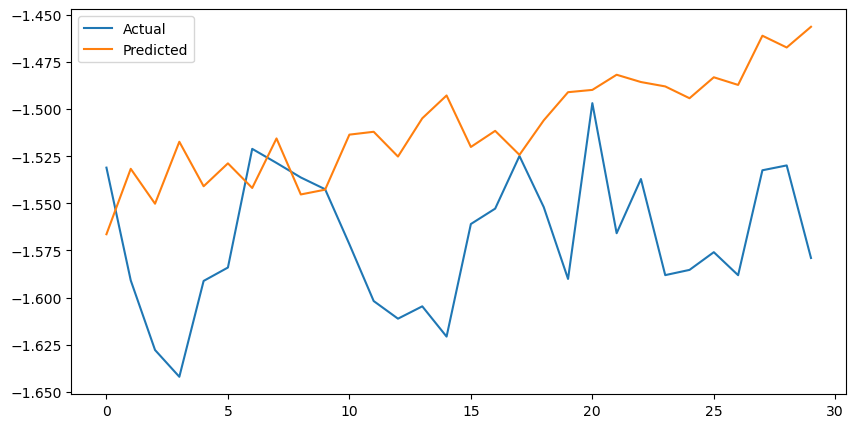

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().detach().numpy().squeeze(0), label="Predicted")
plt.legend()

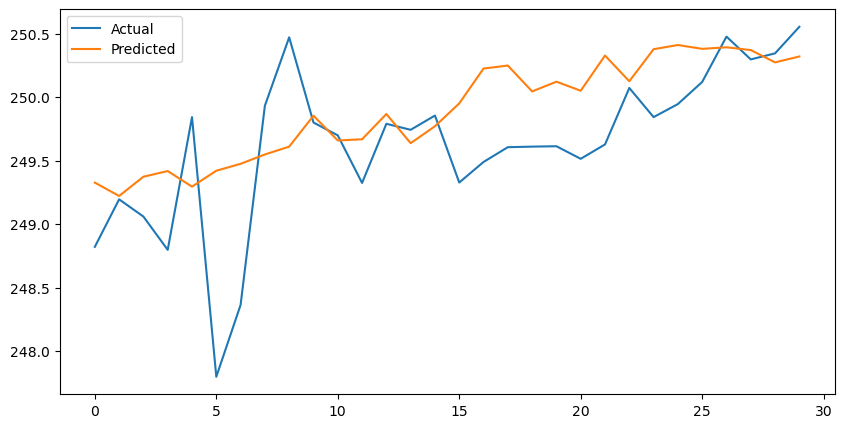

In [32]:
model1.eval()
y_test_label = test_tensor_labels_1[20]
y_test_seq = test_tensor_seq_1[20]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un[20], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Avg Error for model 1 on dataset 1

In [33]:
model1.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0017593784072082895


### Avg Error for model 1 on dataset 2

In [34]:
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0070641573781038735


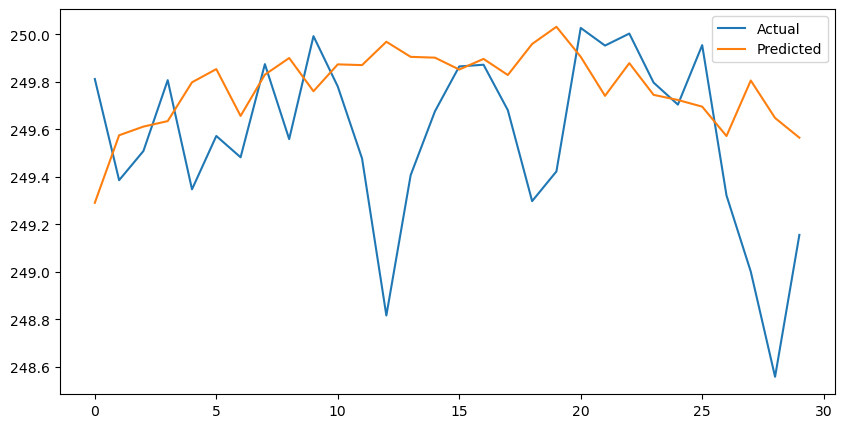

In [35]:
model1.eval()
y_test_label = test_tensor_labels_2[200]
y_test_seq = test_tensor_seq_2[200]
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un[200], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Avg error for model 1 on dataset 3

In [36]:
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.005628893915855794


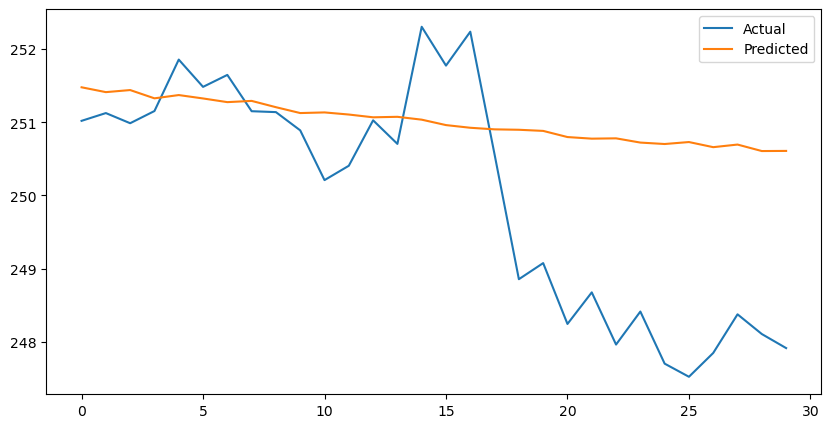

In [37]:
model1.eval()
y_test_label = test_tensor_labels_3[10]
y_test_seq = test_tensor_seq_3[10]
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un[10], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Avg error for model 1 dataset 4 

In [38]:
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0086831900699524


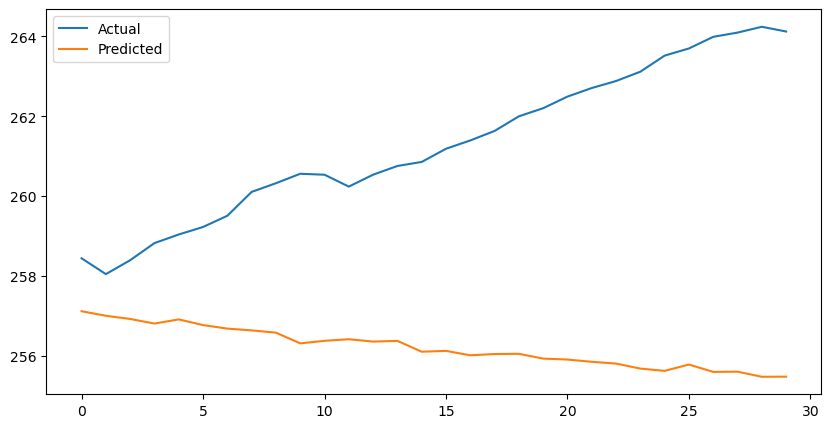

In [39]:
model1.eval()
y_test_label = test_tensor_labels_4[14]
y_test_seq = test_tensor_seq_4[14]
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un[14], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

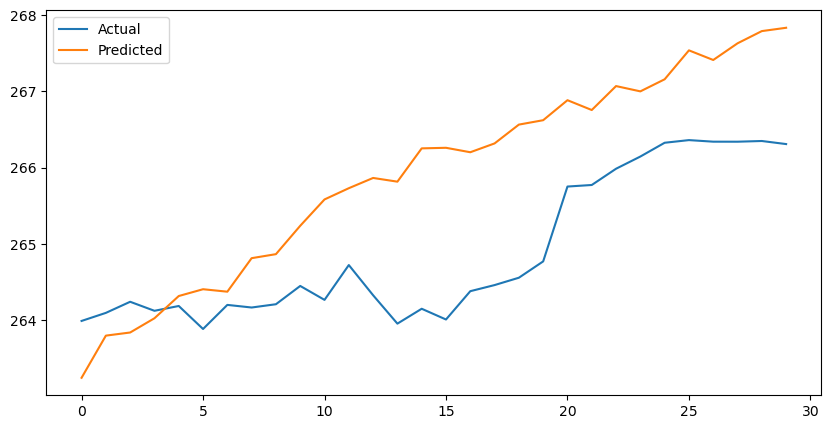

In [40]:
model1.eval()
y_test_label = test_tensor_labels_4[40]
y_test_seq = test_tensor_seq_4[40]
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un[40], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Train Model 2

In [41]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to(device)  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)

In [42]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model2(train_seq_tensor2)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.47651782631874084


Epoch 10, Train Loss: 0.47374558448791504
Epoch 20, Train Loss: 0.46722790598869324
Epoch 30, Train Loss: 0.44026243686676025
Epoch 40, Train Loss: 0.2942219078540802
Epoch 50, Train Loss: 0.14003179967403412
Epoch 60, Train Loss: 0.11226078122854233
Epoch 70, Train Loss: 0.0792689248919487
Epoch 80, Train Loss: 0.05983249470591545
Epoch 90, Train Loss: 0.05040860176086426
Epoch 100, Train Loss: 0.046324439346790314
Epoch 110, Train Loss: 0.04462781548500061
Epoch 120, Train Loss: 0.04353655129671097
Epoch 130, Train Loss: 0.04258845001459122
Epoch 140, Train Loss: 0.041745856404304504
Epoch 150, Train Loss: 0.04100599139928818
Epoch 160, Train Loss: 0.04031829163432121
Epoch 170, Train Loss: 0.03964751213788986
Epoch 180, Train Loss: 0.038971979171037674
Epoch 190, Train Loss: 0.038259223103523254
Epoch 200, Train Loss: 0.03744437173008919
Epoch 210, Train Loss: 0.036335356533527374
Epoch 220, Train Loss: 0.034281615167856216
Epoch 230, Train Loss: 0.031021643429994583
Epoch 240, Trai

In [43]:
torch.save(model2.state_dict, 'model2_30step')

### Avg error model 2 dataset 1

In [44]:
model2.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = model2(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.005874925472766815


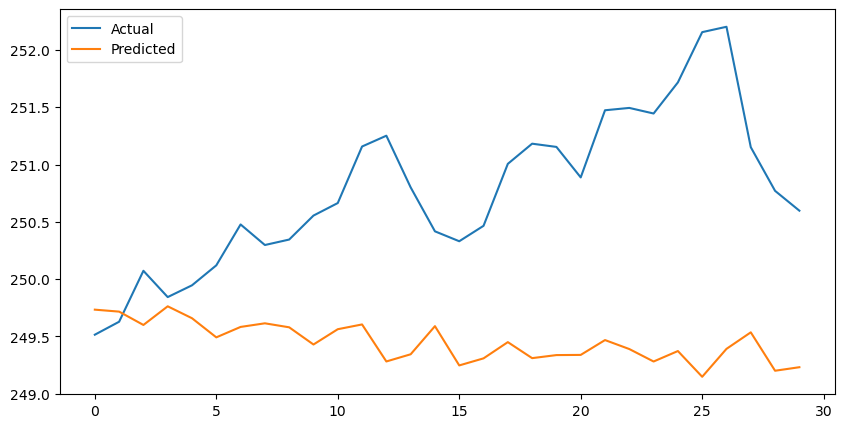

In [45]:
model2.eval()
y_test_label = test_tensor_labels_1[40]
y_test_seq = test_tensor_seq_1[40]
with torch.no_grad():
    y_pred_test = model2(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un[40], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Avg error for model 2 dataset 2

In [46]:
model2.eval()
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = model2(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0025799809601230396


### Avg error model 2 dataset 3

In [47]:
model2.eval()
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = model2(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.007350273115042091


### Avg error model 2 dataset 4

In [48]:
model2.eval()
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = model2(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.00886918547686812


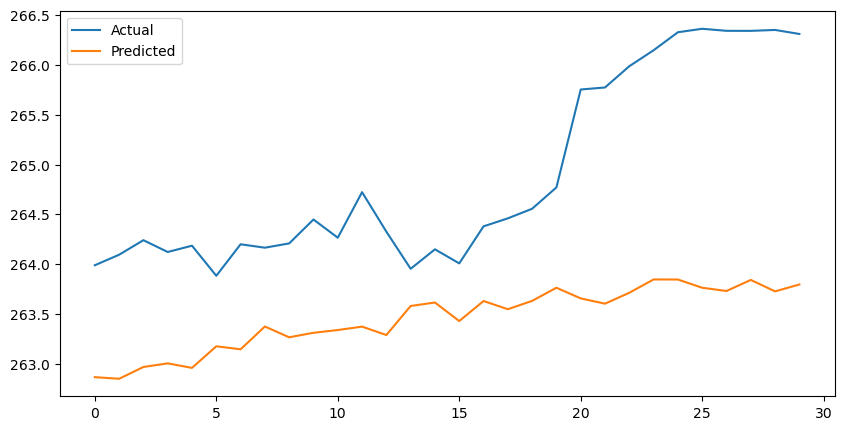

In [49]:
model2.eval()
y_test_label = test_tensor_labels_4[40]
y_test_seq = test_tensor_seq_4[40]
with torch.no_grad():
    y_pred_test = model2(y_test_seq.unsqueeze(0))
y_pred_test = y_pred_test.squeeze(0).cpu().numpy()* fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un[40], label="Actual")
plt.plot(y_pred_test, label="Predicted")
plt.legend()

### Train model 3

In [50]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device)  # Use "cuda" if you have a GPU
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=1e-4)

In [51]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model3(train_seq_tensor3)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.46908217668533325
Epoch 10, Train Loss: 0.46627870202064514
Epoch 20, Train Loss: 0.45930981636047363
Epoch 30, Train Loss: 0.4298864006996155
Epoch 40, Train Loss: 0.2649131715297699
Epoch 50, Train Loss: 0.15300409495830536
Epoch 60, Train Loss: 0.12274482101202011
Epoch 70, Train Loss: 0.10412152856588364
Epoch 80, Train Loss: 0.09317916631698608
Epoch 90, Train Loss: 0.0862697958946228
Epoch 100, Train Loss: 0.08150921761989594
Epoch 110, Train Loss: 0.07756160199642181
Epoch 120, Train Loss: 0.07429153472185135
Epoch 130, Train Loss: 0.07140056043863297
Epoch 140, Train Loss: 0.06875918060541153
Epoch 150, Train Loss: 0.06622376292943954
Epoch 160, Train Loss: 0.06368523836135864
Epoch 170, Train Loss: 0.061037443578243256
Epoch 180, Train Loss: 0.05816759169101715
Epoch 190, Train Loss: 0.054963886737823486
Epoch 200, Train Loss: 0.05136848986148834
Epoch 210, Train Loss: 0.04771032556891441
Epoch 220, Train Loss: 0.04440685361623764
Epoch 230, Train Loss: 

In [52]:
torch.save(model3.state_dict, 'model3_30step')

### Avg error model 3 dataset 1

In [53]:
model3.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = model3(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.007886575778224634


### Avg error model 3 dataset 2

In [54]:
model3.eval()
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = model3(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.007787557334498967


### Avg error model 3 dataset 3

In [55]:
model3.eval()
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = model3(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.002095747678491202


### Avg error model 3 dataset 4

In [56]:
model3.eval()
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = model3(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.009553035235123526


### Train model 4

In [57]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model4 = model4.to(device)  # Use "cuda" if you have a GPU
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)

In [58]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model4.train()
    
    optimizer4.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model4(train_seq_tensor4)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion4(y_pred, train_label_tensor4)
    loss.backward()
    optimizer4.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4555029571056366
Epoch 10, Train Loss: 0.4518679082393646
Epoch 20, Train Loss: 0.44576117396354675
Epoch 30, Train Loss: 0.4242281913757324
Epoch 40, Train Loss: 0.302346795797348
Epoch 50, Train Loss: 0.22005151212215424
Epoch 60, Train Loss: 0.17622590065002441
Epoch 70, Train Loss: 0.1385112702846527
Epoch 80, Train Loss: 0.10607374459505081
Epoch 90, Train Loss: 0.07124978303909302
Epoch 100, Train Loss: 0.050929151475429535
Epoch 110, Train Loss: 0.04467993974685669
Epoch 120, Train Loss: 0.04271547123789787
Epoch 130, Train Loss: 0.04164540767669678
Epoch 140, Train Loss: 0.0407232828438282
Epoch 150, Train Loss: 0.03990933671593666
Epoch 160, Train Loss: 0.039207082241773605
Epoch 170, Train Loss: 0.038523219525814056
Epoch 180, Train Loss: 0.03783806413412094
Epoch 190, Train Loss: 0.03714173287153244
Epoch 200, Train Loss: 0.036414794623851776
Epoch 210, Train Loss: 0.03563019633293152
Epoch 220, Train Loss: 0.0347464494407177
Epoch 230, Train Loss: 0.0

In [59]:
torch.save(model4.state_dict, 'model4_30step')

### Avg error model 4 dataset 1

In [60]:
model4.eval()
error = 0
n_sequences = len(test_tensor_seq_1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_1[i]
    y_test_label = test_labels_1_un[i]
    y_pred_test = model4(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * first_piece.std().values + first_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.01010110294518887


### Avg error model 4 dataset 2

In [61]:
model4.eval()
error = 0
n_sequences = len(test_tensor_seq_2)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_2[i]
    y_test_label = test_labels_2_un[i]
    y_pred_test = model4(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * second_piece.std().values + second_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.007867270624110523


### Avg error model 4 dataset 3

In [62]:
model4.eval()
error = 0
n_sequences = len(test_tensor_seq_3)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_3[i]
    y_test_label = test_labels_3_un[i]
    y_pred_test = model4(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * third_piece.std().values + third_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.006497651718243482


### Avg error model 4 dataset 4

In [63]:
model4.eval()
error = 0
n_sequences = len(test_tensor_seq_4)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = test_tensor_seq_4[i]
    y_test_label = test_labels_4_un[i]
    y_pred_test = model4(y_test_seq.unsqueeze(0))
    # un-normalize prediction and label
    y_pred_test = y_pred_test.squeeze(0).detach().cpu().numpy() * fourth_piece.std().values + fourth_piece.mean().values
    mare = MARE_np(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 0.0013931699713145157
